In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#the main lib here is the statmodel
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA

## Stock Prices Forecasting
For our practical class we will be forecasting the stock prices of some of the biggest stock markets in the world. This will be a guide on how to structure your Time Series Forecasting Project.

## 1. Problem Statement

S&P 500 is a stock market index tracking the stock performance of 500 leading companies listed on stock exchanges in the United States. The index represents the financial health and performance of the US economy. Forecasting the future prices of the index is important for fund managers, banks and investors to measure and prepare for how risky the market might be as well as guide them on when to invest more money and when to pull back.

In this project, we are going to use the historical stock prices of the S&P 500, from 1994-2018 to forecast future prices, we will test out and compare the performance of different time series models.



## 2. Loading and Exploring your data (EDA)

In [2]:
# read the data
df=pd.read_csv(r'D:\Advanced_Machine_Learning\datasets\Stock_prices.csv.csv')

In [3]:
df.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


In [4]:
df.tail()

,date,spx,dax,ftse,nikkei
6264,23/01/2018,2839.130362,13559.60,7731.827774,24124.15
6265,24/01/2018,2837.544008,13414.74,7643.428966,23940.78
6266,25/01/2018,2839.253031,13298.36,7615.839954,23669.49
6267,26/01/2018,2872.867839,13340.17,7665.541292,23631.88
6268,29/01/2018,2853.528411,13324.48,7671.533300,23629.34


Just like in any ML workflow, the first place to begin is checking for missingness.

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6269 entries, 0 to 6268
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6269 non-null   object 
 1   spx     6269 non-null   float64
 2   dax     6269 non-null   float64
 3   ftse    6269 non-null   float64
 4   nikkei  6269 non-null   float64
dtypes: float64(4), object(1)
memory usage: 245.0+ KB


The first thing I notice is that, our date column is not the correct data type. All time-series should be a date-time object. Second, the date column should be the index of the dataframe

In [6]:
#convert date column to datetime object
df['date']=pd.to_datetime(df['date'],errors='coerce',dayfirst=True)

In [7]:
df.set_index('date',inplace=True)

In [8]:
df.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


Also, the stock markets usually run during the week and close over the weekend, meaning our stock prices change from Monday to Friday, and there are no changes on Saturday and Sunday.So let's confirm that our data is accurate and reflect the stock prices during the active market days.

In [9]:
df_trading = df[df.index.dayofweek < 5]

In [10]:
df_trading.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6269 entries, 1994-01-07 to 2018-01-29
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   spx     6269 non-null   float64
 1   dax     6269 non-null   float64
 2   ftse    6269 non-null   float64
 3   nikkei  6269 non-null   float64
dtypes: float64(4)
memory usage: 244.9 KB


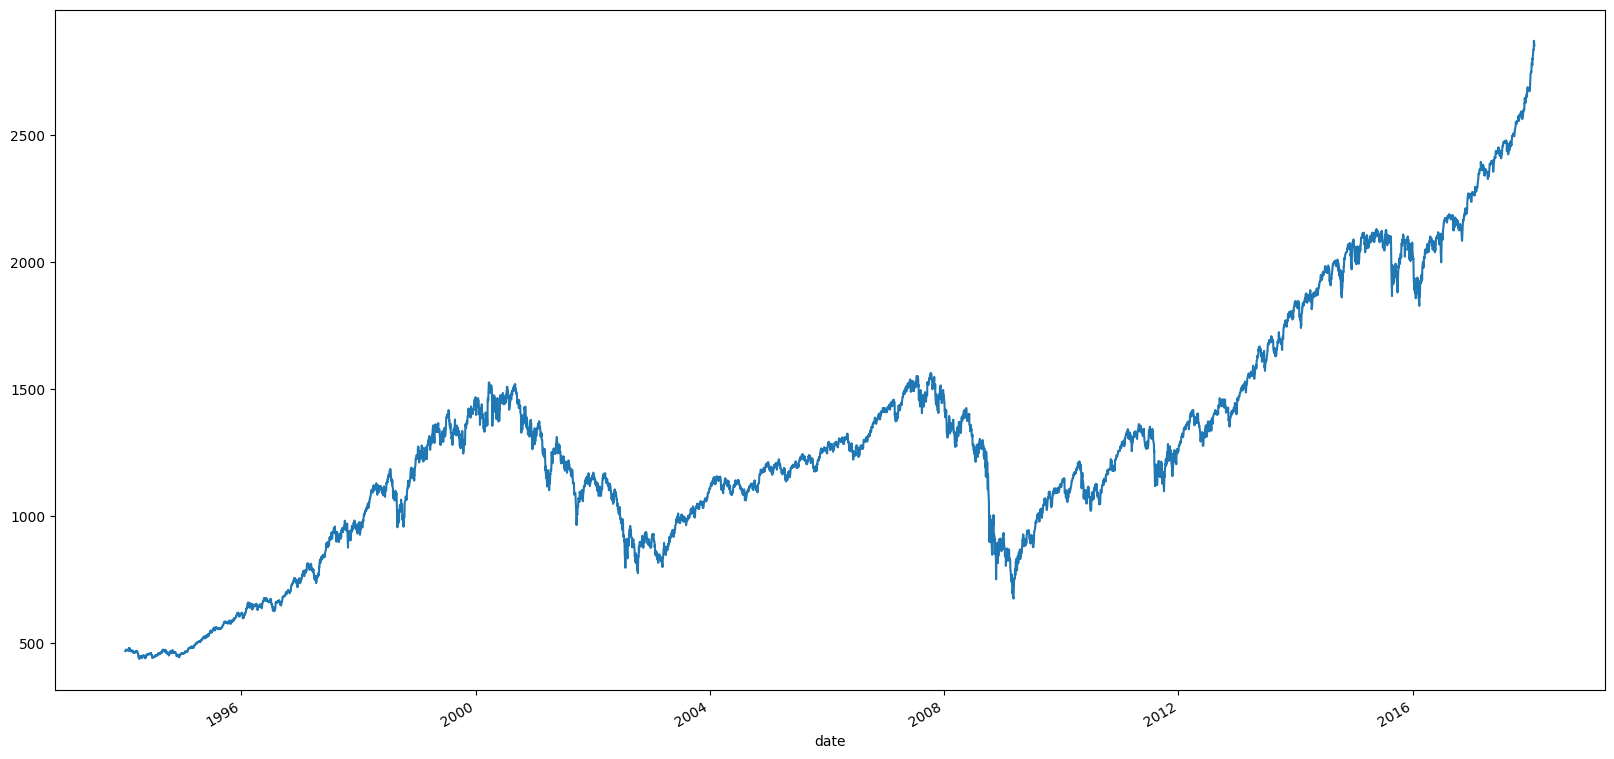

In [11]:
plt.figure(figsize=(20,10))
df_trading['spx'].plot()
plt.show()

So from the plot above, I can see some slight trend- the time series is increasing in trend. I also suspect a seasonal component. I know, it can be confusing, a great way to confirm if your data has seasonality and/or trend is to perform a time-series decomposition. This just means breaking down the time-series into its trend, seasonal and residual (noise) component. We use the statsmodels library for this

Now, for time-series decomposition you have 2 options, you can perform naive decomposition or a more advanced technique. We have 2 approaches under naive, additive or multiplicative. In additive, we assume that the timeseries is a sum of the time components and multiplicative we assume its a product.

**When to choose between additive and multiplicative**
Generally, use an additive decomposition when seasonal variation is constant over time and then use multiplicative when you notice your seasonal effects become bigger with the trend. For me, I used multiplicative, because the seasonal variance is not constant.

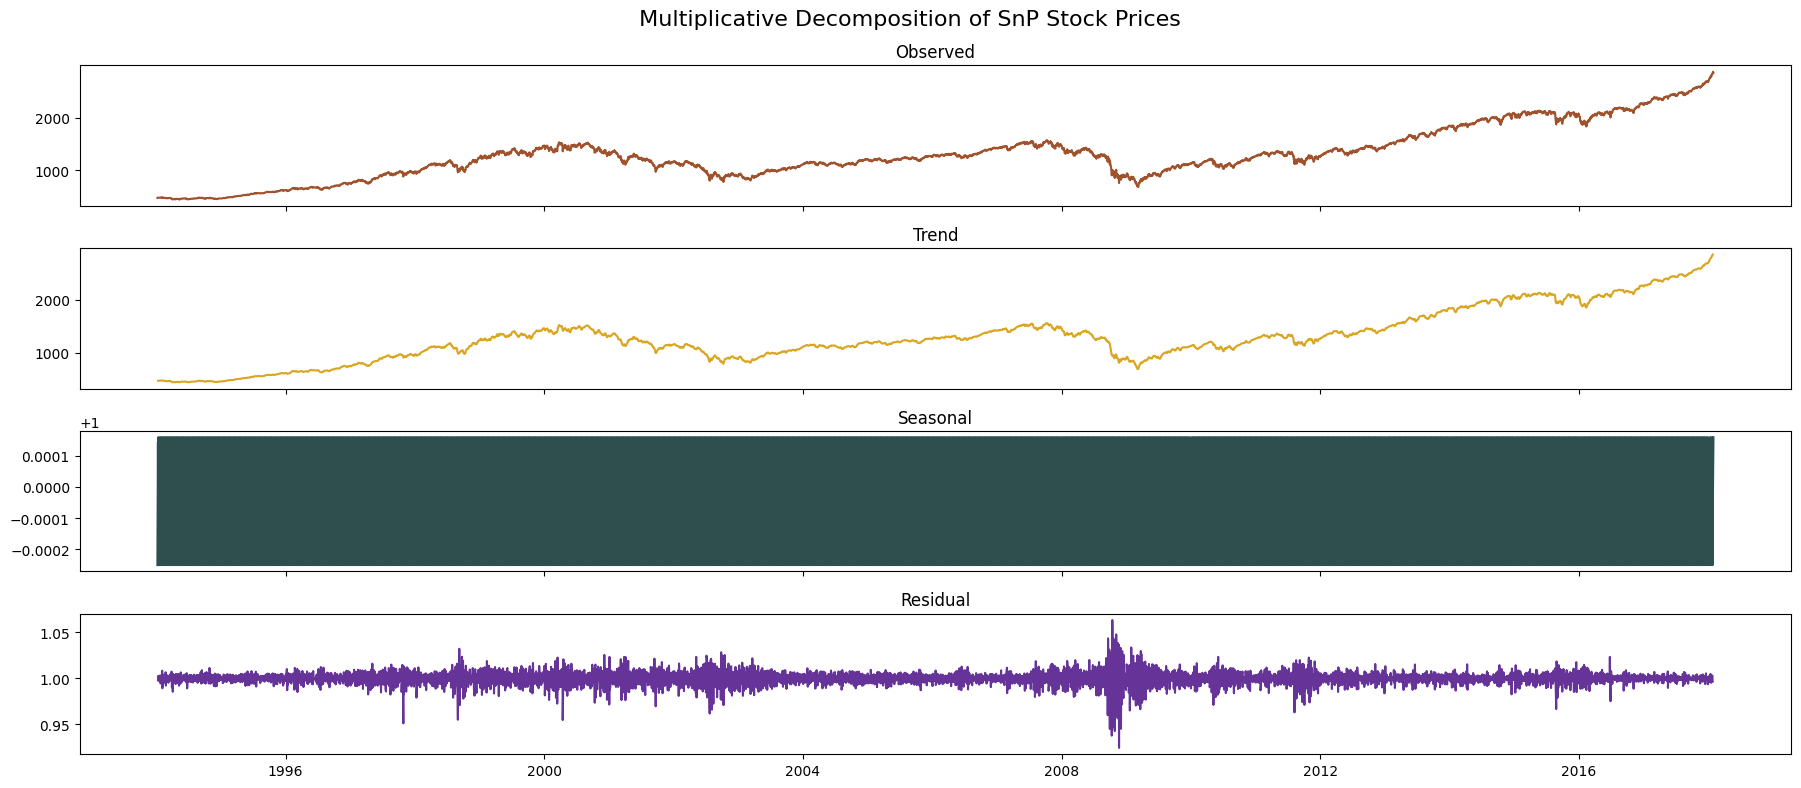

In [12]:
result = seasonal_decompose(df['spx'], model='multiplicative', period=5)


# Plot and save classical decomp components
fig, axs = plt.subplots(4, 1, figsize=(18, 8), sharex=True)

axs[0].plot(result.observed, color='sienna')
axs[0].set_title('Observed')

axs[1].plot(result.trend, color='goldenrod')
axs[1].set_title('Trend')

axs[2].plot(result.seasonal, color='darkslategrey')
axs[2].set_title('Seasonal')

axs[3].plot(result.resid, color='rebeccapurple')
axs[3].set_title('Residual')

plt.suptitle(' Multiplicative Decomposition of SnP Stock Prices', fontsize=16)
plt.tight_layout()

What the above decomposition plot tells us is, there is no seasonality in our time series data. Which checks out for stock price data-stock prices are highly volatile, so it makes sense that the decomposition did not find any repeating pattern every 5 days.
I used a more advanced decomposition technique called STL- Seasonal and Trend decomposition using Loess, just to be sure (and to give you another reference in case you need it), and it confirmed that indeed my time series data has no seasonality.

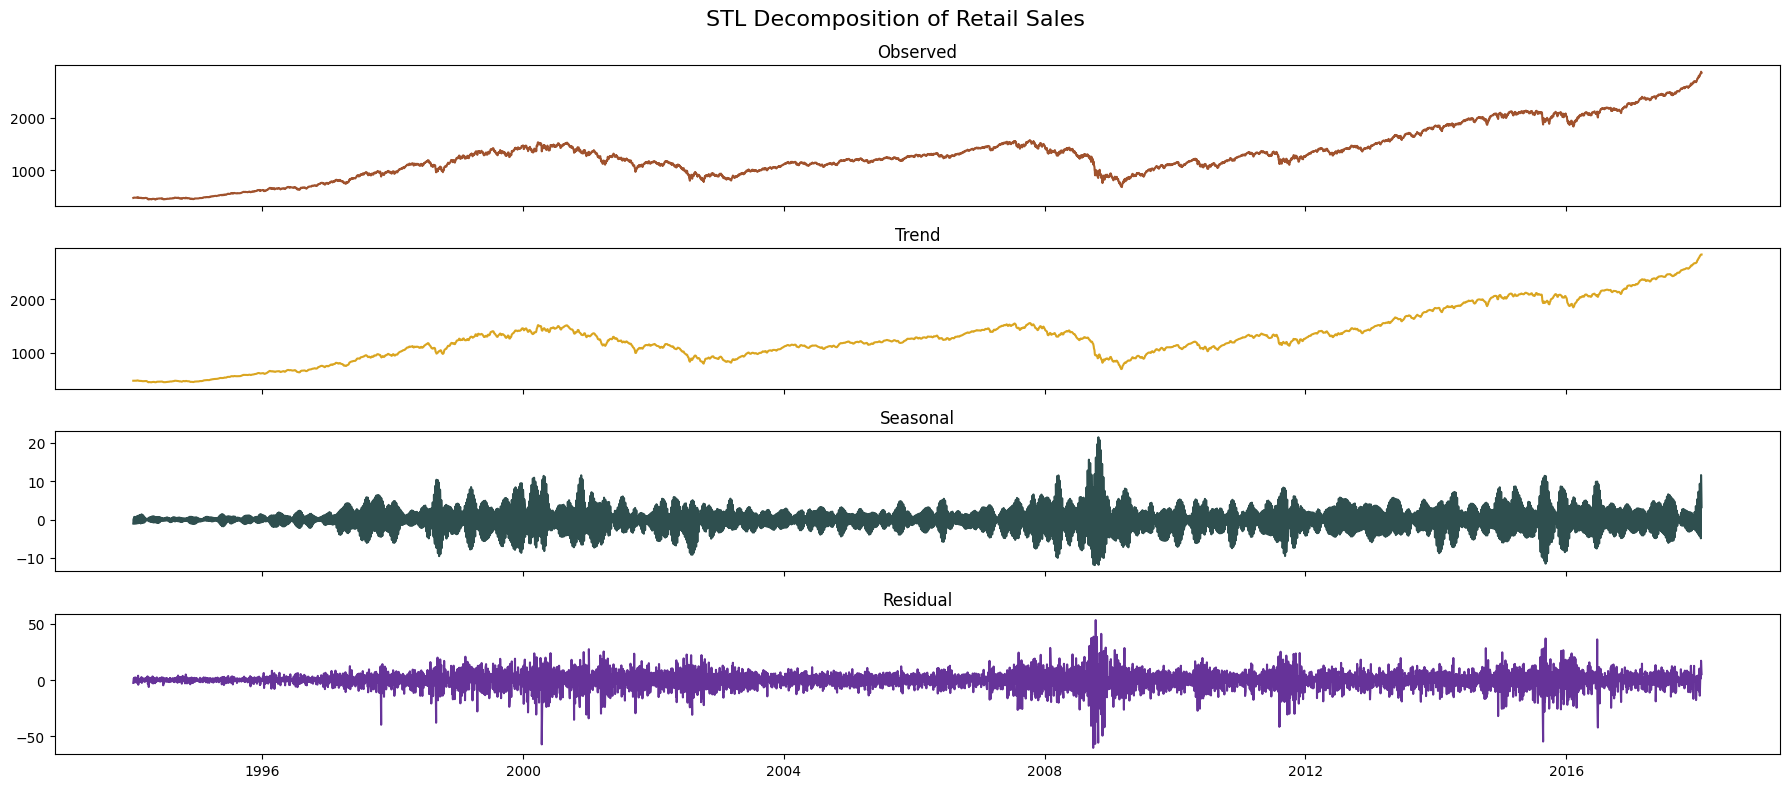

In [13]:
# Apply STL decomposition
stl = STL(df_trading['spx'], seasonal=13,period=5)
result = stl.fit()

# Plot and save STL components
fig, axs = plt.subplots(4, 1, figsize=(18, 8), sharex=True)

axs[0].plot(result.observed, color='sienna')
axs[0].set_title('Observed')

axs[1].plot(result.trend, color='goldenrod')
axs[1].set_title('Trend')

axs[2].plot(result.seasonal, color='darkslategrey')
axs[2].set_title('Seasonal')

axs[3].plot(result.resid, color='rebeccapurple')
axs[3].set_title('Residual')

plt.suptitle('STL Decomposition of Retail Sales', fontsize=16)
plt.tight_layout()
plt.show()

#### Insights from Time-Series Decomposition
- The time series has no seasonality and therefore, I do not need any models like SARIMA that has a seasonal component.
- The trend component explains most of the variability in our time-series data
- The time series is non-stationary as it has trend

#### Checking for Stationarity

In [14]:
result = adfuller(df_trading['spx'])

In [15]:
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

# Decision based on p-value
if result[1] <= 0.05:
    print("Reject the null hypothesis (H0). The time series is stationary.")
else:
    print("The p values is more than 0.05,Fail to reject the null hypothesis (H0). The time series is non-stationary.")

ADF Statistic: 1.0724042027036529
p-value: 0.9949740839827675
Critical Values:
	1%: -3.4313967180469573
	5%: -2.862002556554404
	10%: -2.5670162159104
The p values is more than 0.05,Fail to reject the null hypothesis (H0). The time series is non-stationary.


## 3. Data Pre-Processing

We have learned from our EDA that our data is non-stationary, and that the non-stationarity is likely because of the trend. Our first pre-processing step therefore is to make our data stationary by addressing the trend component. For trend, which means it is the mean that is non-stationary, simple trend differencing would suffice. In case we had seasonanily, which is variance non-stationary- seasonal differencing or log/box-cox transformations would be the best.

Let's proceed with our trend (mean) differencing

In [16]:
#difference the stock prices, first order differencing

diff_spx = df_trading['spx'].diff(periods=1).dropna()
print(diff_spx)

date
1994-01-10     5.370000
1994-01-11    -1.140000
1994-01-12     0.040000
1994-01-13    -1.700000
1994-01-14     2.440000
                ...    
2018-01-23     6.156262
2018-01-24    -1.586354
2018-01-25     1.709023
2018-01-26    33.614808
2018-01-29   -19.339428
Name: spx, Length: 6268, dtype: float64


Now let's plot the differenced time series and confirm that it is now stationary. Is it stationary? Why do you think so?

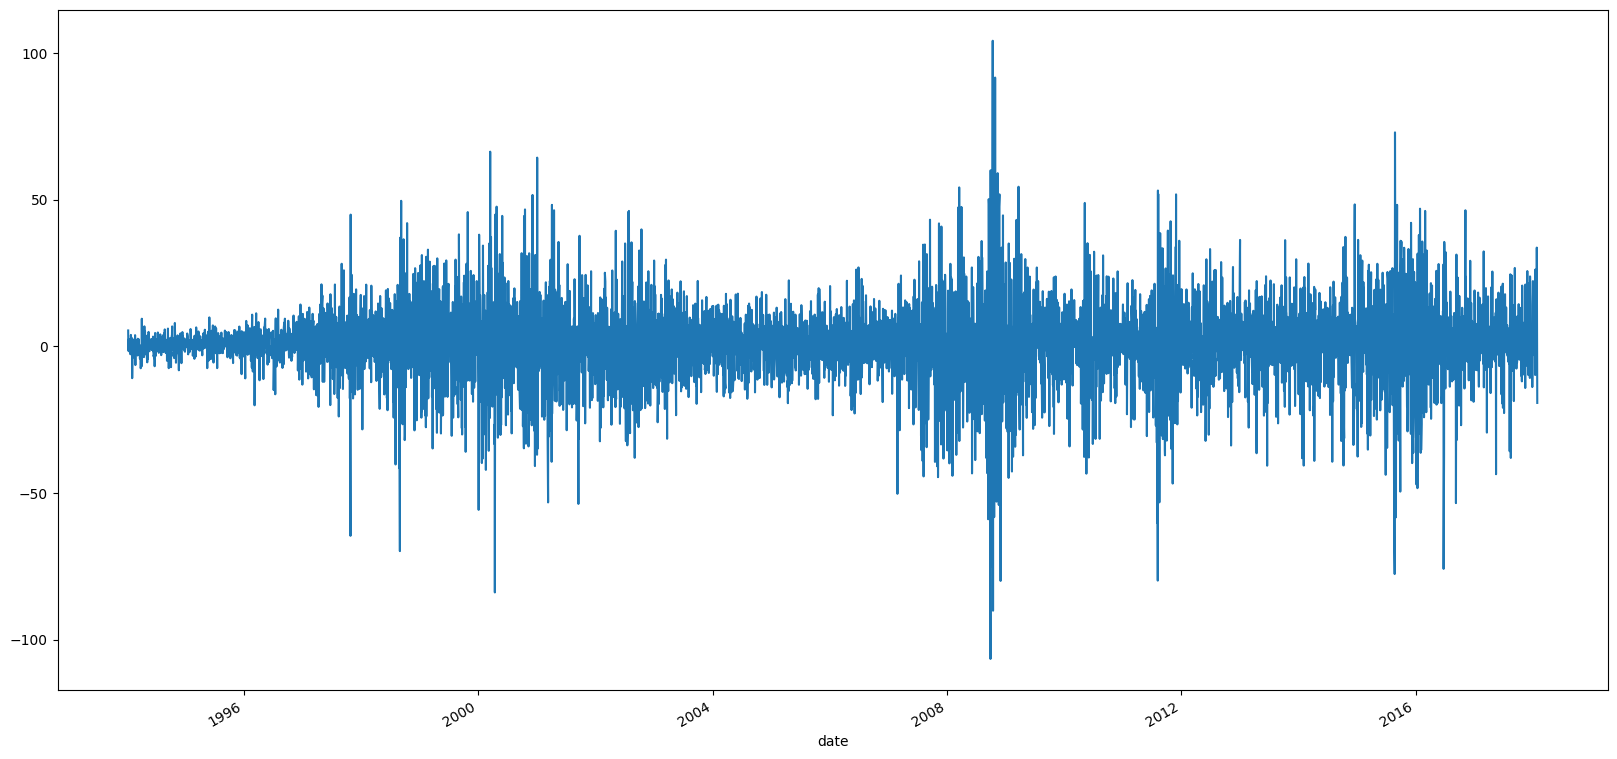

In [17]:
plt.figure(figsize=(20,10))
diff_spx.plot()
plt.show()

### Autocorrelation

<Figure size 1000x300 with 0 Axes>

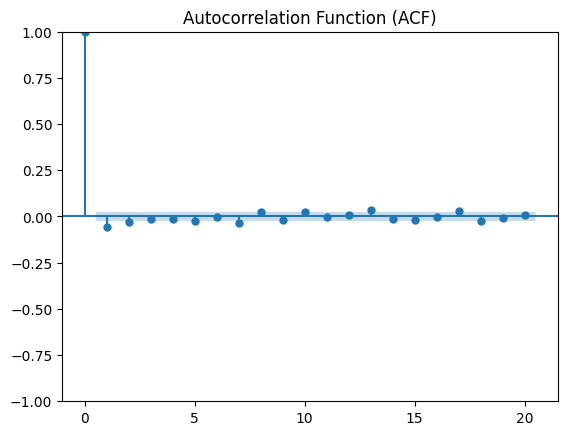

In [18]:
plt.figure(figsize=(10, 3))

# Plot ACF
plot_acf(diff_spx,lags=20, title='Autocorrelation Function (ACF)')
plt.show()


<Figure size 1000x100 with 0 Axes>

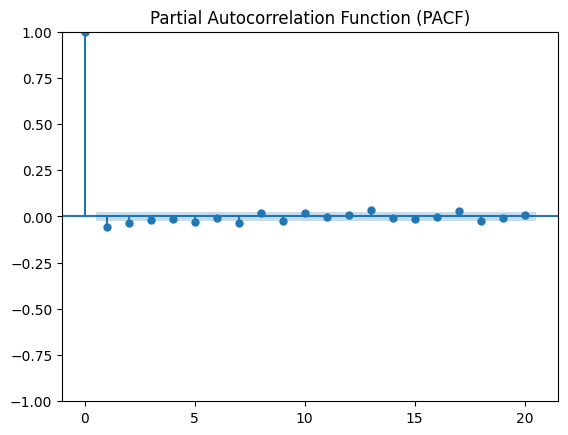

In [19]:
plt.figure(figsize=(10, 1))

# Plot PACF
plot_pacf(diff_spx,method='ols',lags=20,title='Partial Autocorrelation Function (PACF)')
plt.show()


#### Insights from ACF/PACF plots
From the ACF plot, the autocorrelation coefficient cuts off after lag 1( though we can also test for 2), so our parameter q for the MA model is 1. From the PACF plot, the coefficient also cuts off after lag one, so our value for p for the AR model is 1(though we can test our 2).

So we are going to try to fit an ARMA model of ARMA(1,1) and try ARMA(2,2)

### 4. Modelling

Alright, remember in the last class we learned about ARMA and ARIMA, the only difference between these two time series models is that ARIMA handles the differencing internally, which means you feed it non-stationary data. For ARMA, it expects stationary (differenced time series) data. Since we have already differenced our data, I will only be testing ARMA models with different parameters and compare their performances.

##### Train-Test Split

In [20]:
df_trading.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [21]:
df_trading = df_trading[['spx']]
df_trading.head()

,spx
date,
1994-01-07,469.90
1994-01-10,475.27
1994-01-11,474.13
1994-01-12,474.17
1994-01-13,472.47


In [22]:
split_point = int(len(diff_spx) * 0.8)  

train= df_trading['spx'].iloc[:split_point] # Data used for fitting
test= df_trading['spx'].iloc[split_point:]   # Data used for evaluating forecasts

print(f"Total data points: {len(diff_spx)}")
print(f"Training data points: {len(train)}")
print(f"Testing data points: {len(test)}")

Total data points: 6268
Training data points: 5014
Testing data points: 1255


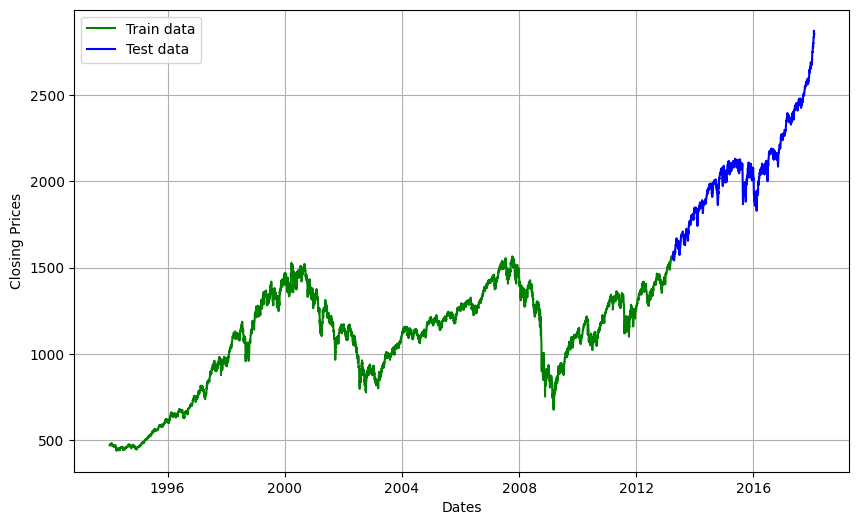

In [23]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train, 'green', label='Train data')
plt.plot(test, 'blue', label='Test data')
plt.legend()

In [24]:
test.head()

date
2013-04-03    1553.686978
2013-04-04    1559.979316
2013-04-05    1553.278930
2013-04-08    1563.071269
2013-04-09    1568.607909
Name: spx, dtype: float64

In [25]:
#Now fit the models
arma11_model = ARIMA(train.values, order=(1, 1, 1))
arma11_fit = arma11_model.fit()
print(arma11_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5014
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -20047.024
Date:                Thu, 22 Jan 2026   AIC                          40100.047
Time:                        16:10:38   BIC                          40119.607
Sample:                             0   HQIC                         40106.902
                               - 5014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6091      0.062      9.751      0.000       0.487       0.732
ma.L1         -0.6765      0.057    -11.969      0.000      -0.787      -0.566
sigma2       174.1877      1.768     98.521      0.0

In [26]:
# Lets try another model
arma22_model = ARIMA(train.values, order=(2, 1, 2))
arma22_fit = arma22_model.fit()
arma22_fit.summary()


d:\Advanced_Machine_Learning\adml-env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Advanced_Machine_Learning\adml-env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5014
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -20046.000
Date:                Thu, 22 Jan 2026   AIC                          40102.000
Time:                        16:10:39   BIC                          40134.599
Sample:                             0   HQIC                         40113.424
                               - 5014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2201      0.128     -1.713      0.087      -0.472       0.032
ar.L2          0.5556      0.086      6.471      0.000       0.387       0.724
ma.L1          0.1483      0.128      1.159      0.247      -0.103       0.399
ma.L2         -0.6006      0.091     -6.635      0.000      -0.778      -0.423
sigma2       174.1164      1.776     98.026      0.000     170.635     177.598
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7326.34
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.27   Skew:                            -0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Looks like the ARMA(1,1) model performs better, the next step is to check the residuals to confirm that the model has adequately captured the autocorrelation and systematic patterns in the time series. If it has done so, we expect that the residuals will look like white noise.

Think about it this way, if the residuals- simply the difference between the predicted and observed stock prices at time t are not random, if they exhibit some kind of pattern it means our model did not fit our data very well. It did not learn well.

If the residuals are not White Noise, it means:You have not chosen the correct model orders ($p$ and $q$).The model is misspecified (e.g., you need to add seasonality, handle non-constant variance, or include external variables).

#### Auto-ARIMA
AutoARIMA is an automated algorithm that finds the best parameters for an ARIMA (Autoregressive Integrated Moving Average) model, a statistical method for time series forecasting, by using tests like KPSS/ADF for differencing (d) and optimizing AIC/BIC for AR (p) and MA (q) components, saving users from manually testing countless combinations to efficiently predict future trend

To apply auto-arima, you have to install the 'pmdarima package', then import the necessary module
``` pip install pmdarima``` 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=40132.692, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40111.203, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=40109.409, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40132.069, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=40100.023, Time=1.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=40101.414, Time=2.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=40101.411, Time=1.87 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=40105.382, Time=0.94 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=40106.505, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=40101.958, Time=4.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=40100.047, Time=0.52 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 11.786 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:      

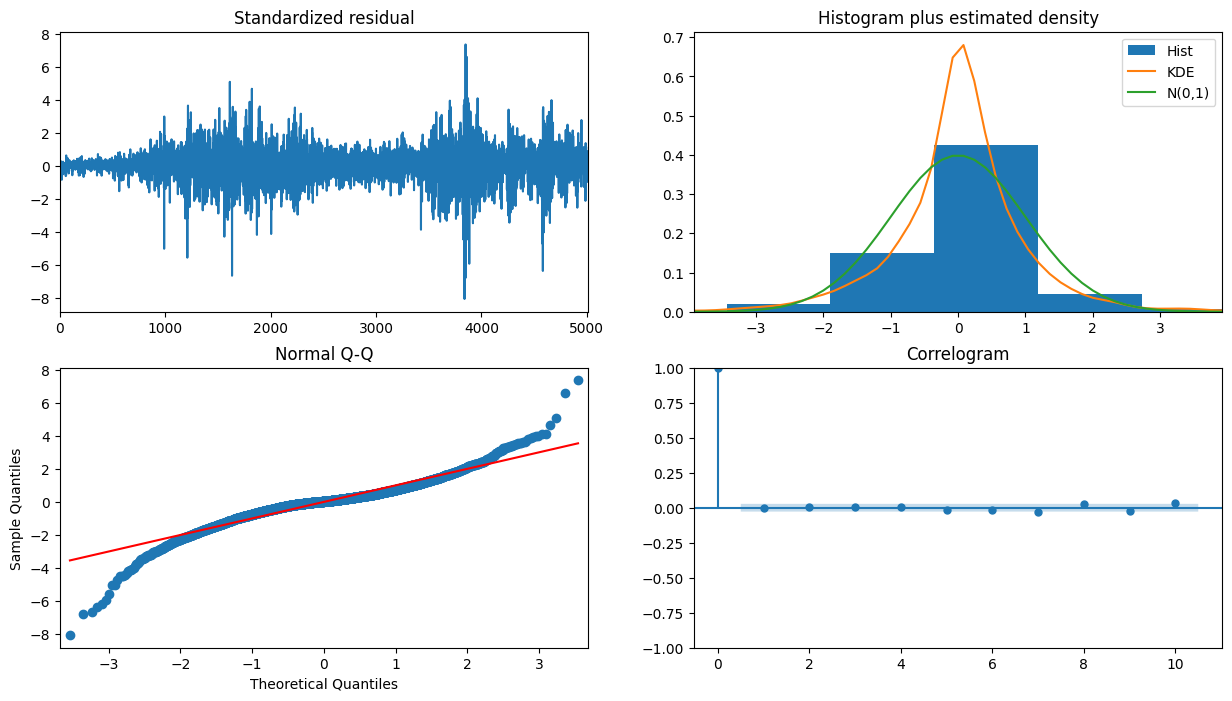

In [27]:
from pmdarima.arima import auto_arima
model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [28]:
#As a result, the Auto ARIMA model assigned the values 1, 1, and 2 to, p, d, and q, respectively.

#Modeling
# Build Model
model = ARIMA(train, order=(1,1,1))  
fitted = model.fit()  
print(fitted.summary())

d:\Advanced_Machine_Learning\adml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Advanced_Machine_Learning\adml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Advanced_Machine_Learning\adml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    spx   No. Observations:                 5014
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -20047.024
Date:                Thu, 22 Jan 2026   AIC                          40100.047
Time:                        16:10:56   BIC                          40119.607
Sample:                             0   HQIC                         40106.902
                               - 5014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6091      0.062      9.751      0.000       0.487       0.732
ma.L1         -0.6765      0.057    -11.969      0.000      -0.787      -0.566
sigma2       174.1877      1.768     98.521      0.0

#### 4.1 Residual Diagnosis

In [29]:
#get the residuals
residuals = arma11_fit.resid


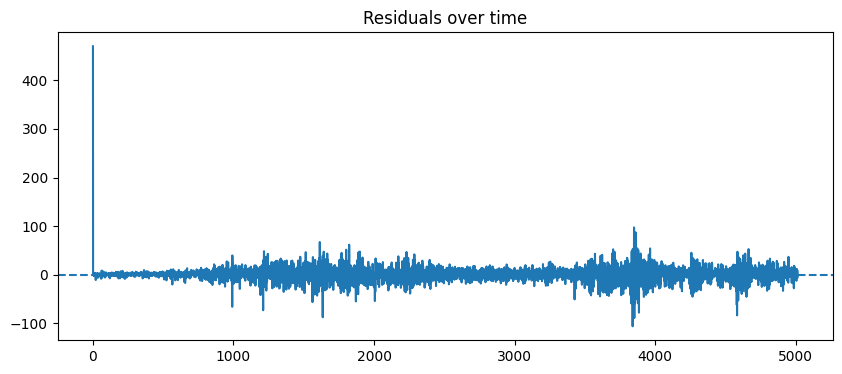

In [30]:
#plot the residuals over time
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.axhline(0, linestyle='--')
plt.title("Residuals over time")
plt.show()


You want to see:

- Fluctuations around 0
- No clear trend
- No obvious seasonality
- No big “blocks” of high or low variance

Clearly, this confirms that our residuals are indeed random and that our model has learned the autocorrelated component well.

### 5. Forecasting & Model Evaluation

In [31]:
# Forecast the same number of steps as the test set
n_steps = len(test)
forecast_obj = fitted.get_forecast(steps=n_steps)

# Extract predicted mean and confidence intervals
y_pred = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()
#convert them to series to make it easier to plot
fc_series = pd.Series(y_pred.values, index=test.index)
lower_series = pd.Series(conf_int.iloc[:, 0].values, index=test.index)
upper_series = pd.Series(conf_int.iloc[:, 1].values, index=test.index)


d:\Advanced_Machine_Learning\adml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\Advanced_Machine_Learning\adml-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [32]:
fc_series

date
2013-04-03    1569.804782
2013-04-04    1569.532232
2013-04-05    1569.366218
2013-04-08    1569.265098
2013-04-09    1569.203504
                 ...     
2018-01-23    1569.107525
2018-01-24    1569.107525
2018-01-25    1569.107525
2018-01-26    1569.107525
2018-01-29    1569.107525
Length: 1255, dtype: float64

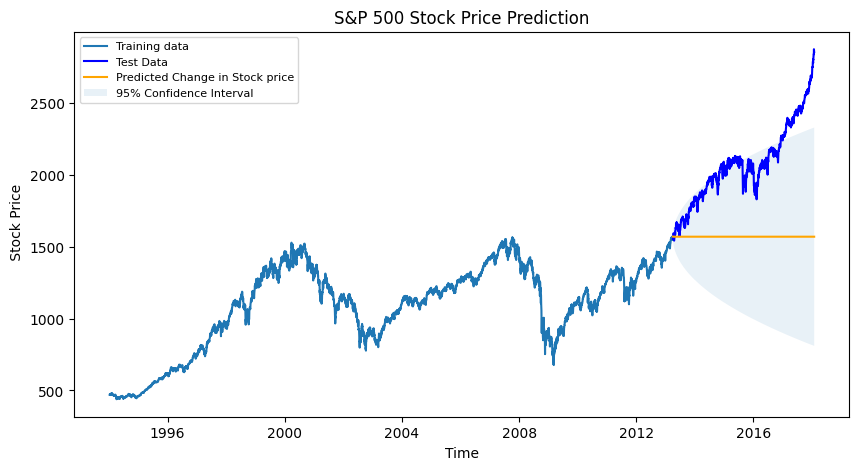

In [33]:
plt.figure(figsize=(10,5), dpi=100)

plt.plot(train, label='Training data')
plt.plot(test, color='blue', label='Test Data')
plt.plot(fc_series, color='orange', label='Predicted Change in Stock price')

plt.fill_between(
    lower_series.index, 
    lower_series, 
    upper_series, 
    alpha=.10, 
    label='95% Confidence Interval'
)

plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


#### Wait a straight line? Weird right?

Something to note, the ARIMA model is not actually forecasting the ***ACTUAL STOCK PRICE***, it is modelling the changes in the stock price, Because we differenced the data, so it is modelling the difference in stock prices. For indices like the S&P 500, these differences (returns) usually behave like noisy data with a mean around zero or a small drift and very weak autocorrelation. When the model looks at that history, it effectively learns: “on average, the next change in price looks similar to what I’ve seen before and doesn’t show a strong predictable pattern.” When we ask ARIMA to forecast many steps ahead, the AR and MA effects fade, the expected future changes converge to a constant, and when those constant changes are added back up, they produce a nearly flat or gently sloping line that starts around the last observed price. So the model’s *best mean prediction* is that prices will hover around the current level, even though the actual test data continues to rise sharply.

The widening blue confidence band is the other crucial part of the story: although the orange mean forecast is flat, the 95% interval fans out over time, which means the model is expressing *growing uncertainty*, not confidence that the price will literally stay constant. 

The ARIMA model is honest about how hard it is to predict future stock prices; it does not see a statistically reliable signal that allows it to “know about” the coming boom, so it keeps the mean forecast steady while admitting that the true price could end up much higher or much lower. This is why ARIMA is often said to be better at modelling the expected level of a series than the dramatic swings, and why in finance we often move to models like ARCH/GARCH to describe changing volatility instead of trying to force ARIMA to chase every movement in price.


###  6. Evaluate Model Performance

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test, y_pred)
rmse = np.sqrt(mean_squared_error(test, y_pred))

print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")



MAE : 505.73
RMSE: 572.62


## Forecasting Stock Market Volatility with ARCH & GARCH 

As we have seen above, our ARIMA model predicts the average mean but fails to capture the extreme volatility we have seen in our stocks data. ARCH (Autoregressive Conditional Heteroskedasticity) and GARCH (Generalized Autoregressive Conditional Heteroskedasticity) models are popular in financial markets because they specifically capture volatility, which is the degree to which stock prices fluctuate. They don’t directly tell you when to buy or sell stocks in terms of predicting exact future prices. Instead, their real-world business applications are primarily related to managing risk, timing, and strategic investment decisions based on volatility.

Example of how they are used in the real-world
When a ARCH/GARCH model indicates increasing future volatility (higher spikes in your volatility forecast), it means the stock price is likely to swing more dramatically, therefore reduce the investment position or hedge to limit potential losses during predicted volatile periods.

In [35]:
# you need to install the arch libary
# pip install arch

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from arch import arch_model
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox


#### 1. Load and Explore Data

In [18]:
# read the data
df=pd.read_csv(r'D:\Advanced_Machine_Learning\datasets\Stock_prices.csv.csv')

In [19]:
#convert date column to datetime object
df['date']=pd.to_datetime(df['date'],errors='coerce',dayfirst=True)
df.set_index('date',inplace=True)

In [20]:
#filter out the data for the S&P 500 stock prices only
df_spx=df[['spx']]

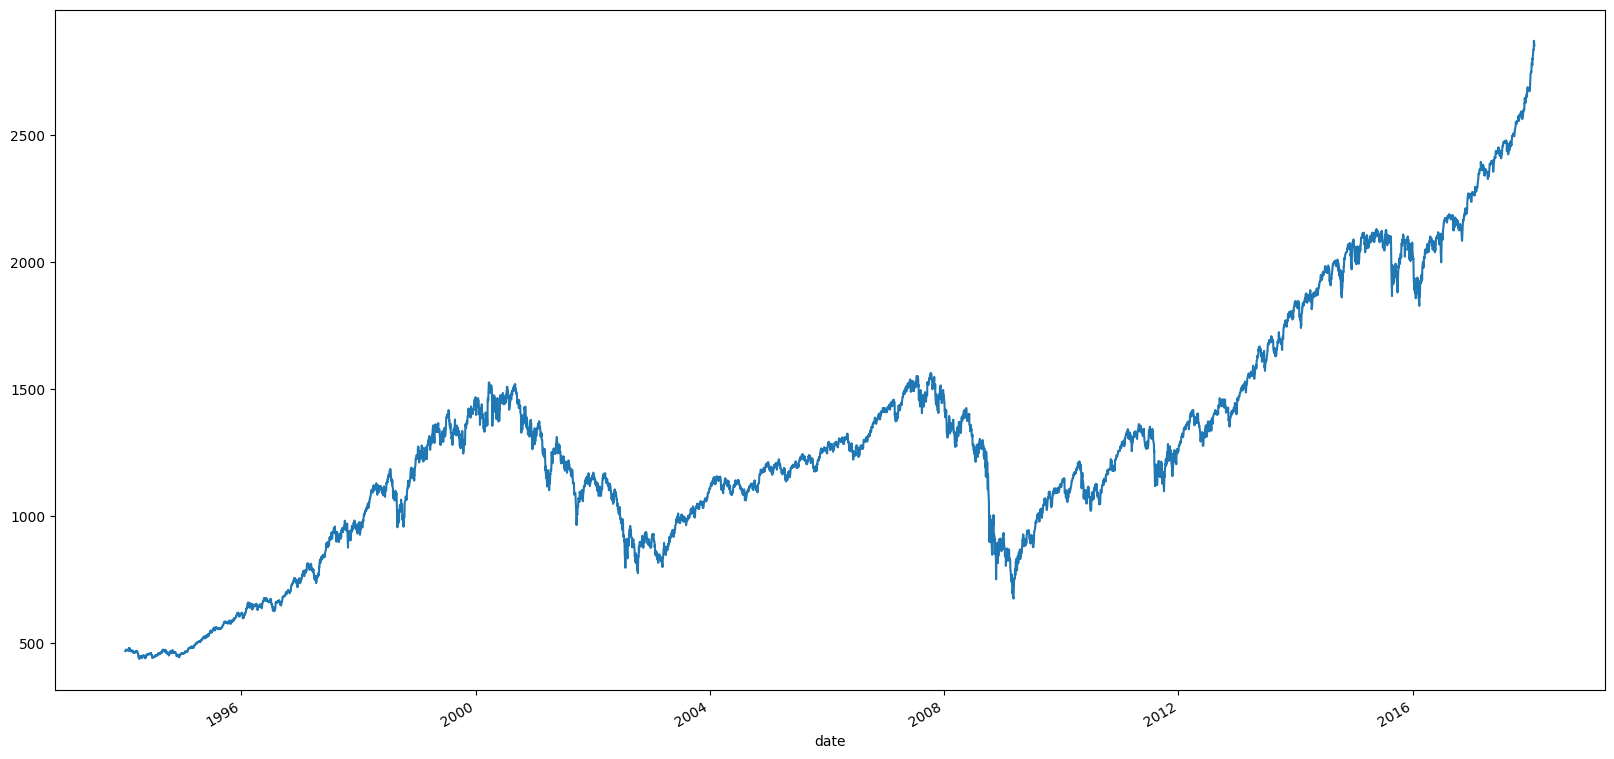

In [21]:
plt.figure(figsize=(20,10))
df_spx['spx'].plot()
plt.show()

#### 2. Data Pre-processing

Let's understand a couple of assumptions of the ARCH and GARCH models before we do any further, so that the next steps make more sense...(stay with me)

We use returns instead of prices in ARCH/GARCH models because prices are non-stationary - they trend upward or downward over time, which violates the fundamental assumption that GARCH requires (stable statistical properties). Returns, on the other hand, are stationary - the percentage change from day to day has consistent properties throughout time regardless of the price level. Additionally, returns are scale-free and comparable across different stocks and time periods (a 5% return means the same thing whether the stock is $10 or $1,000), whereas raw prices are not. Most importantly, GARCH models volatility (how much things change), not price levels, and returns directly capture these changes - they ARE the thing we want to measure the volatility of. If you tried to fit GARCH to raw prices, the model would fail because prices follow a random walk where shocks permanently affect the level, making variance grow over time rather than clustering in the predictable way that GARCH is designed to capture

You can use either simple returns or log of returns, but log of returns are preferred for arch, garch and these types of models, because logs have better statistical properties-making them easier to model. 

In [22]:
#calculate the log of returns
df_spx['Log_Return'] = np.log(df_spx['spx'] / df_spx['spx'].shift(1))

# Drop the first NaN value
df_spx = df_spx.dropna()

# Multiply by 100- this is not a must, but just makes it easier to interpret
df_spx['Log_Return'] = df_spx['Log_Return'] * 100

C:\Users\Wambui\AppData\Local\Temp\ipykernel_10740\592715120.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spx['Log_Return'] = np.log(df_spx['spx'] / df_spx['spx'].shift(1))


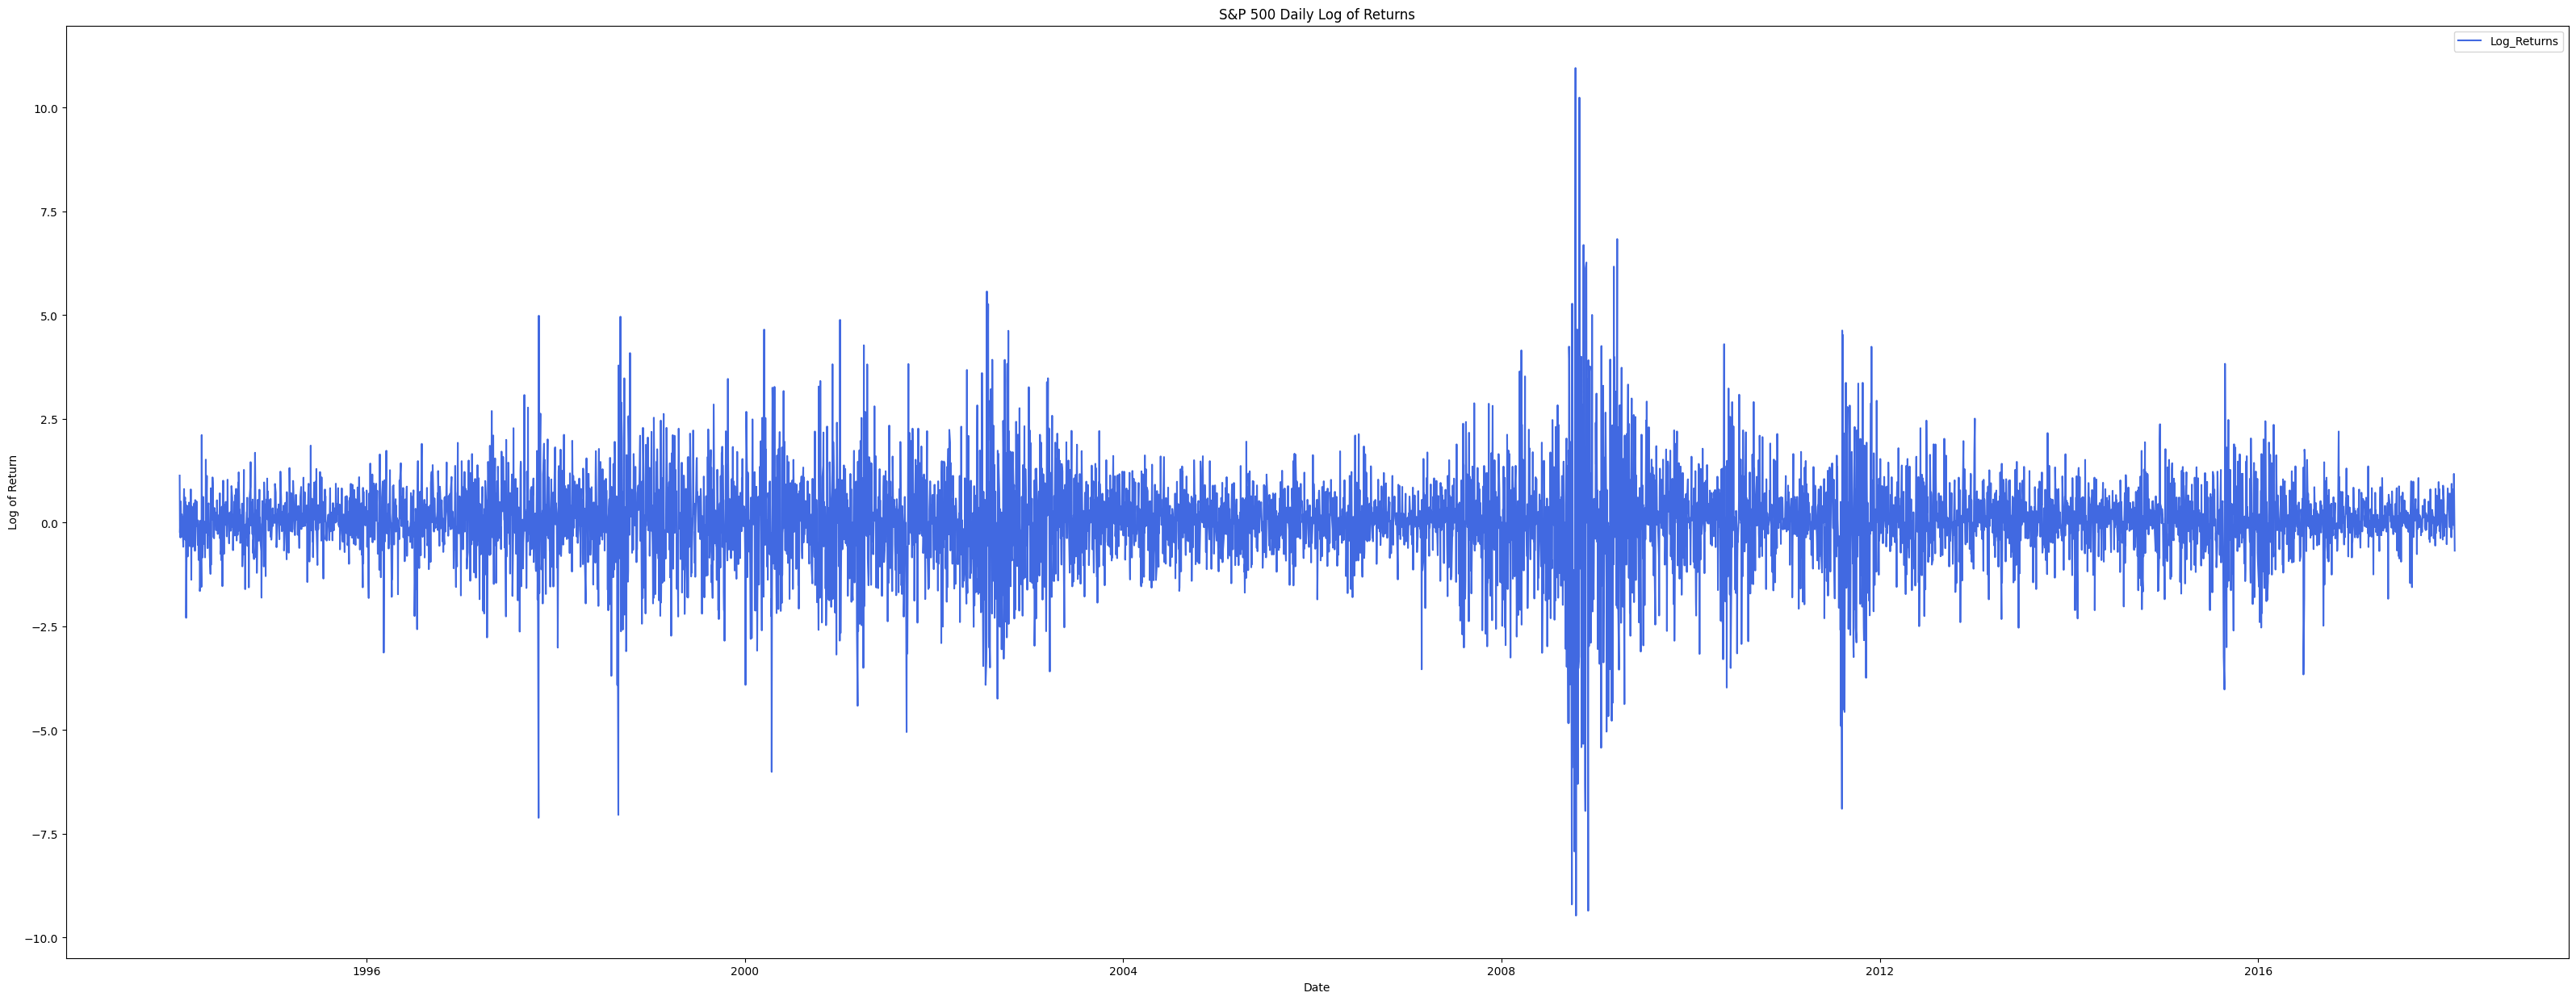

In [23]:
plt.figure(figsize=(40, 15))
plt.plot(df_spx.index, df_spx['Log_Return'], label='Log_Returns', color='royalblue')
plt.title('S&P 500 Daily Log of Returns')
plt.ylabel('Log of Return')
plt.xlabel('Date')
plt.legend()
plt.show()

Can you identify any conditional clustering? 

#### Testing  for ARCH Effects

While we can see volatility in the plot above,we still need to statistically test to determine if we need an ARCH/GARCH model. We call this testing for ARCH effects

The core idea is to check if the variance of the errors is correlated with past values. A simple and effective way to do this is to see if the squared returns(in our case the squared log of returns) are autocorrelated. If they are, it means that large price swings tend to follow other large price swings—the very definition of volatility clustering. There are 2 ways we can test for this:


- ACF plot of squared (log) returns

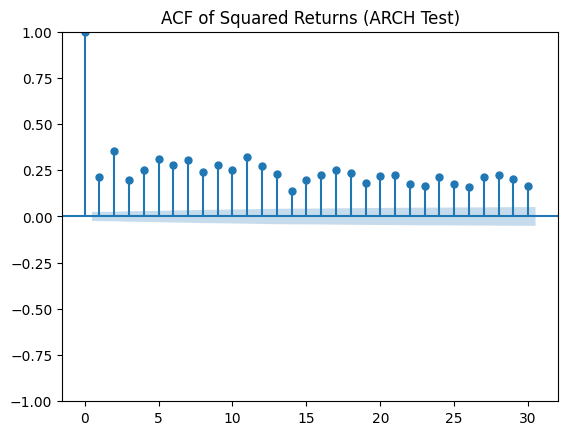

In [24]:
# Plot ACF of squared returns
plot_acf(df_spx['Log_Return']**2, lags=30)
plt.title('ACF of Squared Returns (ARCH Test)')
plt.show()

Can you try and interpret the ACF plot, given what we covered in yesterday's class on ARMA, ARIMA etc time series forecasting?

- The Lung-Box Test

Null Hypothesis (H₀): There is no serial correlation in the squared returns (i.e., no ARCH effects are present).

Alternative Hypothesis (Hₐ): There is serial correlation in the squared returns (i.e., ARCH effects are present).

    **In short ,if the p-value from the test is less than 0.05, use ARCH/GARCH models**

In [25]:
# Perform the Ljung-Box test on the squared scaled returns.
lb_test_results = acorr_ljungbox(df_spx['Log_Return']**2, lags=10, return_df=True)

# Print the results
print("Ljung-Box Test on Squared Returns:")
print(lb_test_results)

Ljung-Box Test on Squared Returns:
        lb_stat      lb_pvalue
1    289.496327   6.401805e-65
2   1080.152313  2.804823e-235
3   1324.936247  5.716292e-287
4   1720.843577   0.000000e+00
5   2329.919106   0.000000e+00
6   2817.739252   0.000000e+00
7   3394.114806   0.000000e+00
8   3760.266583   0.000000e+00
9   4252.149120   0.000000e+00
10  4648.978388   0.000000e+00


#### 3. Fitting the models

##### Train-Test Split the Log returns time-series

In [26]:
split_point = int(len(df_spx) * 0.8)  

train= df_spx['Log_Return'].iloc[:split_point] # Data used for fitting
test= df_spx['Log_Return'].iloc[split_point:]   # Data used for evaluating forecasts

print(f"Total data points: {len(df_spx)}")
print(f"Training data points: {len(train)}")
print(f"Testing data points: {len(test)}")

Total data points: 6268
Training data points: 5014
Testing data points: 1254


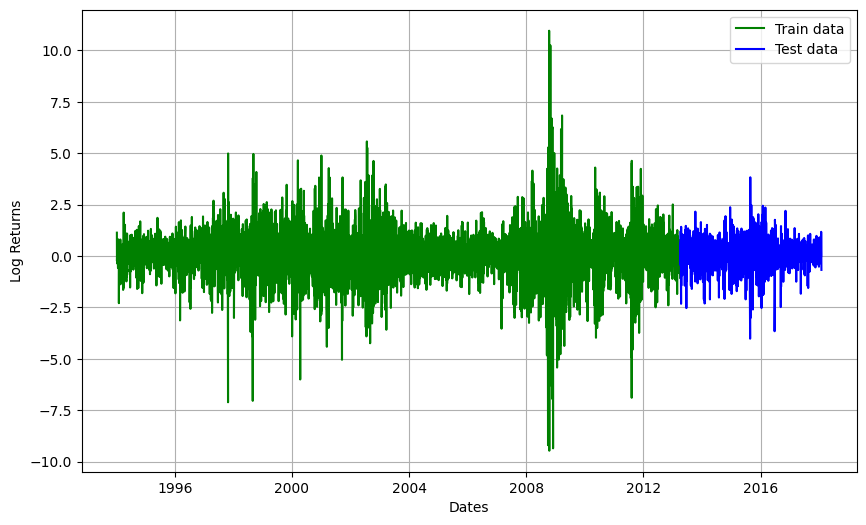

In [27]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Log Returns')
plt.plot(train, 'green', label='Train data')
plt.plot(test, 'blue', label='Test data')
plt.legend()

##### 1. First, we fit a simple ARCH model

In [29]:
from arch import arch_model
am = arch_model(
    train, 
    vol='ARCH', 
    p=1,         # ARCH(1)
    q=0       # q=0 means no GARCH terms
    )
arch_result = am.fit(disp='off') 
print("\nARCH(1,1) model summary:")
print(arch_result.summary())


ARCH(1,1) model summary:
                      Constant Mean - ARCH Model Results                      
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7848.81
Distribution:                  Normal   AIC:                           15703.6
Method:            Maximum Likelihood   BIC:                           15723.2
                                        No. Observations:                 5014
Date:                Thu, Jan 22 2026   Df Residuals:                     5013
Time:                        19:42:04   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0398  1.794e-02

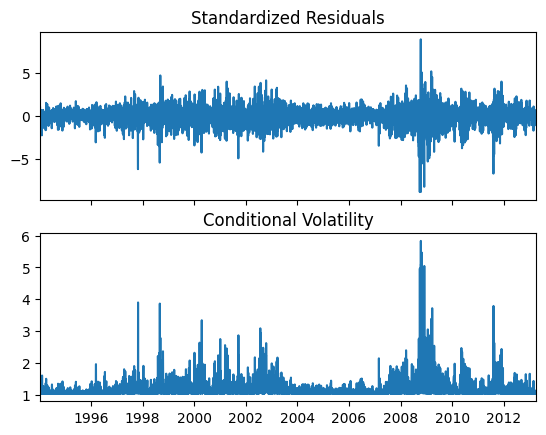

In [34]:
arch_result.plot()
plt.show()

Now its fit another model, GARCH and compare the performance

In [ ]:
gm = arch_model(
    train, 
    vol='GARCH', 
    mean='Zero',
    p=1, 
    q=1,
    dist='normal')

garch_result = gm.fit(disp='off') 

# Print the summary of the model
print("--- GARCH(1,1) Model Results ---")
print(garch_result.summary())

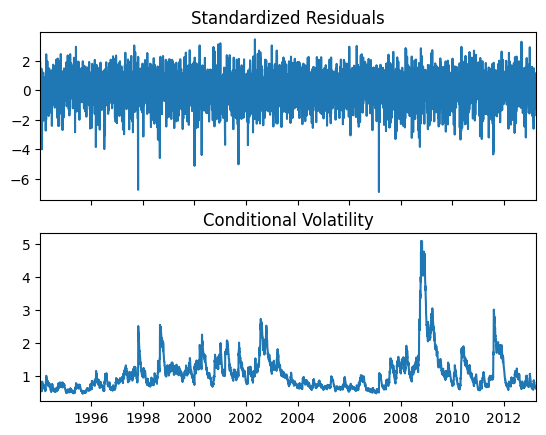

In [36]:
garch_result.plot()
plt.show()

In [32]:
# Create a list of model results and model names
results_list = [garch_result, arch_result]
model_names = ['ARCH(1)', 'GARCH(1,1,1)']

# Create a dictionary to store the metrics
metrics = {
    'Log-Likelihood': [res.loglikelihood for res in results_list],
    'AIC': [res.aic for res in results_list],
    'BIC': [res.bic for res in results_list]
}

# Create a pandas DataFrame for a clean comparison table
comparison_df = pd.DataFrame(metrics, index=model_names)

In [33]:
comparison_df.head()

,Log-Likelihood,AIC,BIC
ARCH(1),-7011.935765,14029.871530,14049.431498
"GARCH(1,1,1)",-7848.807786,15703.615572,15723.175539


### 6. Diagnostic Check of the winning model

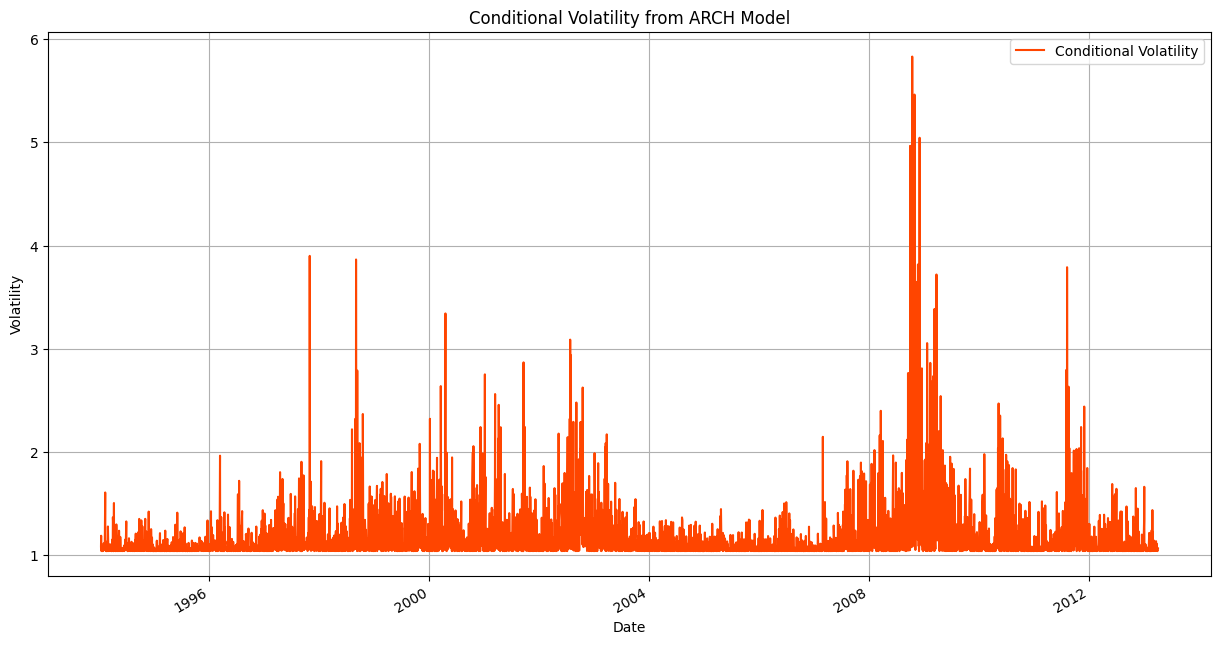

In [43]:
plt.figure(figsize=(15, 8))
arch_result.conditional_volatility.plot(label='Conditional Volatility', color='orangered')
#plt.ylim(0.86,0.90)
#plt.ylim(upper=0.90)
plt.title('Conditional Volatility from ARCH Model')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.grid()
plt.legend()
plt.show()

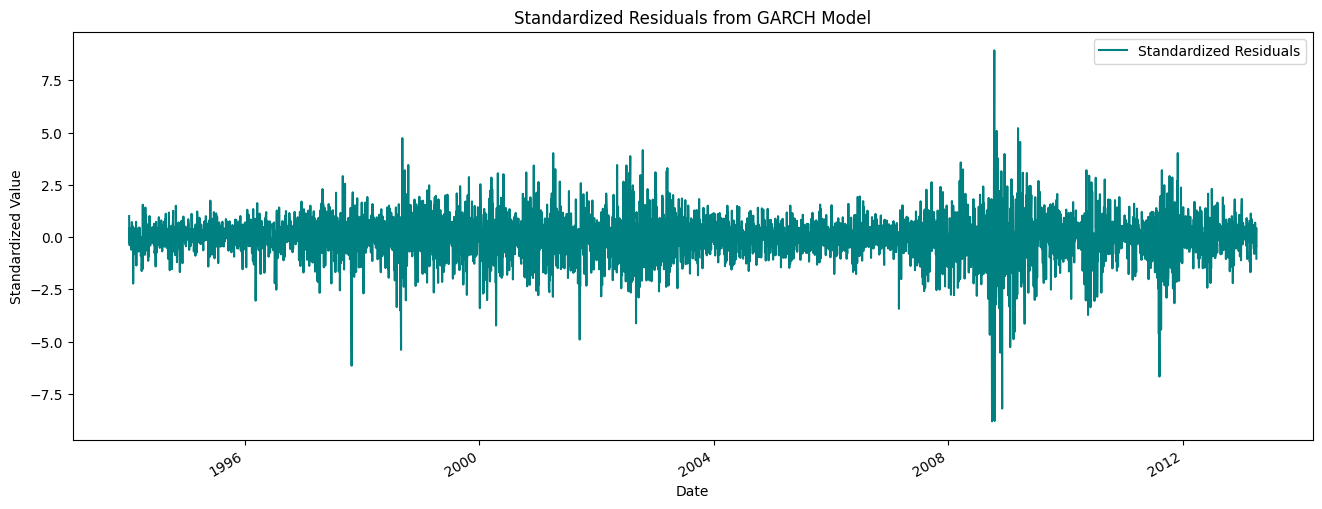

In [ ]:
plt.figure(figsize=(16, 6))
arch_result.std_resid.plot(label='Standardized Residuals', color='teal')
plt.title('Standardized Residuals from ARCH Model')
plt.ylabel('Standardized Value')
plt.xlabel('Date')
plt.legend()
plt.show()

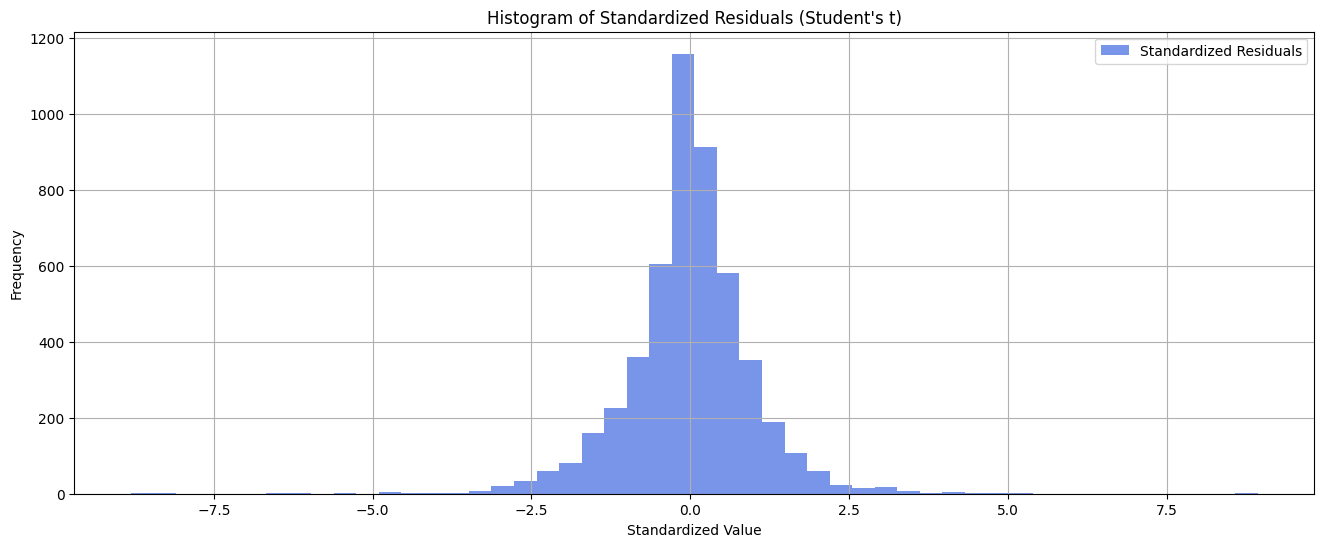

In [ ]:
plt.figure(figsize=(16, 6))
arch_result.std_resid.hist(bins=50, label='Standardized Residuals', color='royalblue', alpha=0.7)
plt.title('Histogram of Standardized Residuals')
plt.xlabel('Standardized Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

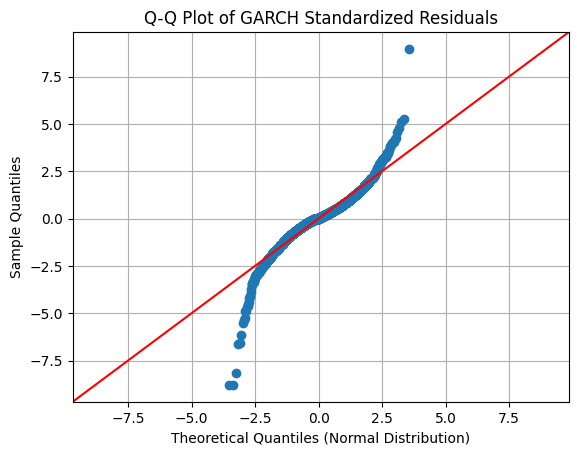

In [46]:
import statsmodels.api as sm
fig = sm.qqplot(arch_result.std_resid ,line='45', fit=True)

plt.title('Q-Q Plot of GARCH Standardized Residuals')
plt.xlabel('Theoretical Quantiles (Normal Distribution)')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

This means we need to change the distribution we assumed when instanciating the arch model

In [42]:
# Perform the Ljung-Box test on the squared standardized residuals
lb_test_diag = acorr_ljungbox(arch_result.std_resid**2, lags=[10], return_df=True)

# Print the results
print("Ljung-Box Test on Squared Standardized Residuals:")
print(lb_test_diag)

Ljung-Box Test on Squared Standardized Residuals:
        lb_stat      lb_pvalue
10  1371.909521  1.151170e-288


### 7. Forecasting Future Volatility

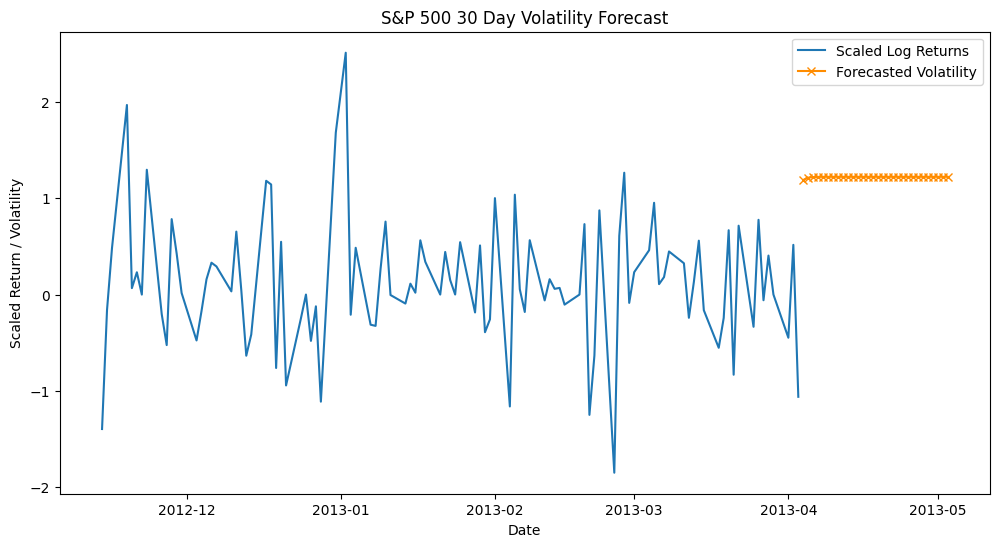

Forecasted Daily Volatility for the Next 30 Days:
h.01    1.189215
h.02    1.212611
h.03    1.218997
h.04    1.220755
h.05    1.221240
h.06    1.221374
h.07    1.221411
h.08    1.221422
h.09    1.221424
h.10    1.221425
h.11    1.221425
h.12    1.221425
h.13    1.221425
h.14    1.221425
h.15    1.221425
h.16    1.221425
h.17    1.221425
h.18    1.221425
h.19    1.221425
h.20    1.221425
h.21    1.221425
h.22    1.221425
h.23    1.221425
h.24    1.221425
h.25    1.221425
h.26    1.221425
h.27    1.221425
h.28    1.221425
h.29    1.221425
h.30    1.221425
Name: 2013-04-03 00:00:00, dtype: float64


In [47]:
# Forecast 14 days into the future
forecast_horizon = 30
forecasts = arch_result.forecast(horizon=forecast_horizon, reindex=False)

# Extract the predicted variance and convert to annualized volatility
forecast_variance = forecasts.variance.iloc[-1]
forecast_volatility = np.sqrt(forecast_variance)

# Get the last date from our original data
last_date = train.index[-1]

# Create a date range for the forecast
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train.tail(100), label='Scaled Log Returns')
plt.plot(forecast_dates, forecast_volatility, label='Forecasted Volatility', color='darkorange', marker='x')
plt.title('S&P 500 30 Day Volatility Forecast')
plt.xlabel('Date')
plt.ylabel('Scaled Return / Volatility')
plt.legend()
plt.show()

print("Forecasted Daily Volatility for the Next 30 Days:")
print(forecast_volatility)